### 0.Imports

In [3884]:
import phik
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import (
    StandardScaler,MinMaxScaler, RobustScaler,
    LabelEncoder
)
from sklearn.metrics import (
    f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from collections import Counter
import warnings
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier 
from sklearn.preprocessing import StandardScaler


In [3885]:
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.chop_threshold', 0.01)

### 1. DF loading

In [3887]:
df = pd.read_csv('/Users/germanchernukhin/Desktop/startups-operations-close-predictions-m-1-33-ds/kaggle_startups_train_28062024.csv')

In [3888]:
df_t = pd.read_csv('/Users/germanchernukhin/Desktop/startups-operations-close-predictions-m-1-33-ds/kaggle_startups_test_28062024.csv')

#### 1.1 Dates & lifetime

Приведем всё к нужному формату и найдем лафтайм

In [3891]:
#reference_date = pd.Timestamp('1970-01-01')

In [3892]:
df['founded_at'] = pd.to_datetime(df['founded_at'], format='%Y-%m-%d')
df['closed_at'] = pd.to_datetime(df['closed_at'], format='%Y-%m-%d')

In [3893]:
df['closed_at'] = df['closed_at'].fillna(pd.Timestamp('2018-01-01'))
df['lifetime'] = (df['closed_at']- df['founded_at'])
df['lifetime'] = df['lifetime'].dt.days.astype('int64')

#### 1.2 Funding span

Создадим кучу признаков с дейттаймом, из которых нам, в итоге почти ничего не понадобится)) Funding span качество модели особенно не улучшил, даже если делить на количество раундов или комбинировать с фандингом (может sin-cos или что-нибудь такое заработает, но я большой пользы для результатов не обнаружил). Last funding at не очень хороший признак (никто в реальном времени не знает, был уже этот последний раунд или нет), но для качества предсказаний он дает результаты чуть лучше, чем first funding at, в итоге оставил только его. 

Для реального использования лучше оставлять first funding at и, вероятно, придется убрать lifetime. Также, вероятно, first funding at и funding span нужен был бы для приблизительного учета инфляции, если бы мы использовали funding total. Накопленная инфляция с начала по конец периода составляет приблизительно 400% в долларах, без хотя бы приблизительного учета фандинг будет, в значительной степени, просто отражением lifetime. 

Для Кэггл я решил использовать максимально простое решение с небольшим количеством признаков, так как без тщательной переработки признаки связанные с фандингом (суммарным, длительностью, числом раундов, синтетические признаки и т.д.) качество предсказаний не улучшали.

In [3896]:
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], format='%Y-%m-%d')
#df['ff'] = df['first_funding_at'] - df['founded_at'] 
#print('Среднее время до превого раунда: ', df['ff'].mean())
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], format='%Y-%m-%d')
df['first_funding_at_y'] = (df['first_funding_at']).dt.year.astype('int64')
df['funding_span_temp'] = (df['last_funding_at'] - df['first_funding_at'])
df['funding_span'] = df['funding_span_temp'].dt.days.astype('int64') + 1

df_t['first_funding_at'] = pd.to_datetime(df_t['first_funding_at'], format='%Y-%m-%d')
df_t['last_funding_at'] = pd.to_datetime(df_t['last_funding_at'], format='%Y-%m-%d')
df_t['first_funding_at_y'] = (df_t['first_funding_at']).dt.year.astype('int64')
df_t['funding_span_temp'] = (df_t['last_funding_at'] - df_t['first_funding_at'])
df_t['funding_span'] = df_t['funding_span_temp'].dt.days.astype('int64') + 1

df = df.drop(columns=['founded_at','closed_at','funding_span_temp'])
df_t = df_t.drop(columns=['funding_span_temp'])

In [3897]:
df['first_funding_at'] = (df['first_funding_at'] - reference_date).dt.days.astype('int64')
df['last_funding_at'] = (df['last_funding_at'] - reference_date).dt.days.astype('int64')

df_t['first_funding_at'] = (df_t['first_funding_at'] - reference_date).dt.days.astype('int64')
df_t['last_funding_at'] = (df_t['last_funding_at']- reference_date).dt.days.astype('int64')

In [3898]:
df.describe()

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_y,funding_span
count,42447.000,52516.000,52516.000,52516.000,52516.000,52516.000,52516.000
mean,18247480.657,1.741,15172.198,15518.687,3140.828,2011.076,347.489
std,187117301.321,1.375,1323.325,1222.569,2147.821,3.614,688.604
min,1.000,1.000,2691.000,2691.000,19.000,1977.000,1.000
25%,336027.500,1.000,14529.000,15006.000,1739.000,2009.000,1.000
50%,2000000.000,1.000,15544.000,15947.000,2557.000,2012.000,1.000
75%,10000000.000,2.000,16161.000,16391.000,4018.000,2014.000,428.000
max,30079503000.000,19.000,16774.000,16776.000,17378.000,2015.000,10808.000


In [3899]:
df_t.describe()

,funding_total_usd,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_y,funding_span
count,10547.000,13125.000,13125.000,13125.000,13125.000,13125.000,13125.000
mean,16549102.695,1.714,15178.871,15507.211,3097.610,2011.094,329.340
std,92172825.632,1.319,1336.001,1245.089,2128.357,3.645,658.073
min,1.000,1.000,1200.000,1200.000,52.000,1973.000,1.000
25%,320000.000,1.000,14564.000,14984.000,1726.000,2009.000,1.000
50%,2000000.000,1.000,15553.000,15938.000,2526.000,2012.000,1.000
75%,10000000.000,2.000,16161.000,16385.000,3866.000,2014.000,392.000
max,4715000000.000,15.000,16772.000,16781.000,17167.000,2015.000,7039.000


In [3900]:
#df['funding_total_usd'] = df['funding_total_usd'].fillna(-1000)
#df_t['funding_total_usd'] = df_t['funding_total_usd'].fillna(-1000)
#df = df[df['funding_total_usd']<4715000000.000]
#df = df[df['lifetime']<17167.000]
#df = df[df['funding_span']<7039.000]
#df = df[df['lifetime']>52.000]
#df.shape

#### 1.3 Missing rows

Поищем пропуски визуально

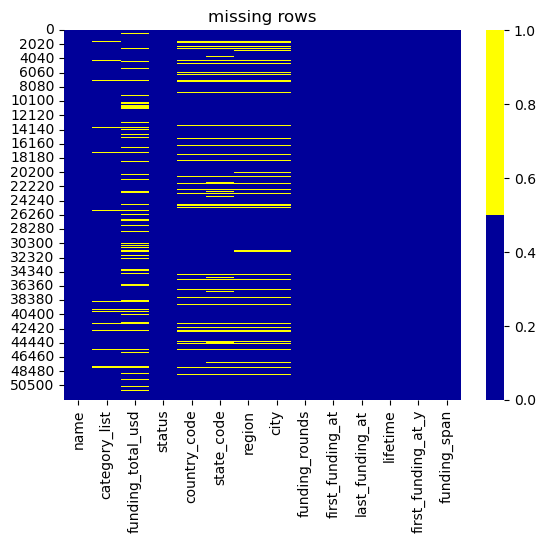

In [3903]:
cols = df.columns[:20]
colours = ['#000099', '#ffff00'] 
plt.title('missing rows')
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

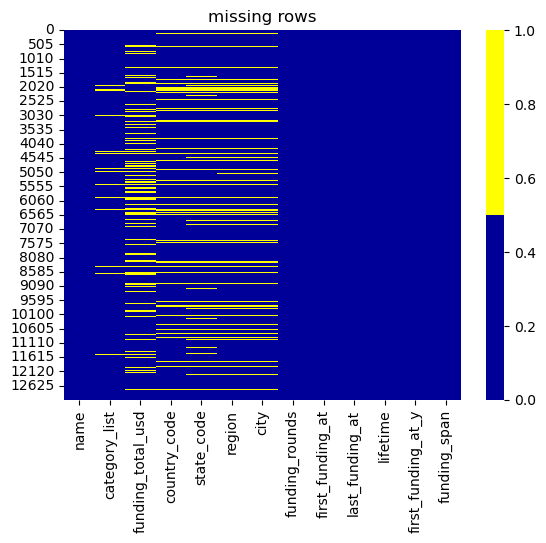

In [3904]:
cols = df_t.columns[:20]
colours = ['#000099', '#ffff00'] 
plt.title('missing rows')
sns.heatmap(df_t[cols].isnull(), cmap=sns.color_palette(colours))
plt.show()

Много пропусков в фандинге, поменьше в странах и категориях. Фандинга показалось многовато, чтобы заполнять средним или медианой. Проверил, влияет ли сам факт непредоставления информации на шансы закрыться, но, к сожалению, особенного положительного эффекта на предсказания не обнаружил (смотрел и отдельно для фандинга и для общего числа пропусков в строке)

### 2. Features

#### 2.1 Country regions

Больше всего у нас стартапов их США, их я разбил на США+штат (у части штат не указан, там просто США). Остальные страны — просто название страны. Пробовал добавлять к другим странам регионы, но получилось хуже.

In [3909]:
df.loc[df['country_code'] == 'USA', 'country_code'] = df['country_code'] + '|' +  df['state_code']
df_t.loc[df_t['country_code'] == 'USA', 'country_code'] = df_t['country_code'] +  '|' + df_t['region']

#df.loc[df['country_code'] != 'USA', 'country_code'] = df['country_code'] + '|' +  df['region']
#df_t.loc[df_t['country_code'] != 'USA', 'country_code'] = df_t['country_code'] +  '|' + df_t['region']

In [3910]:
df['country_code'] = df['country_code'].fillna('--').astype(str)
df_t['country_code'] = df_t['country_code'].fillna('--').astype(str)
all_categories = pd.concat([df['country_code'], df_t['country_code']])

all_categories = set(
    cat.strip() 
    for cat in all_categories )

df['country_code'] = df['country_code'].astype(str)
df_t['country_code'] = df_t['country_code'].astype(str)
category_counts = Counter(df['country_code'])

top_categories_100 = set(cat for cat, count in category_counts.most_common(200))

def group_category(category):
    
    if category in top_categories_100:
        return category
    return 'Others'
 
df['country_region'] = df['country_code'].apply(group_category)
df_t['country_region'] = df_t['country_code'].apply(group_category)

In [3911]:
df['country_region'].value_counts().tail()

country_region
SEN    1
UZB    1
GRD    1
BLM    1
ZMB    1
Name: count, dtype: int64

#### 2.2 Category list

С категориями сложнее. Разбил строки на элементы по |, потом нашел самые часто встречающиеся. Они ушли в category list. Добавил Second category из того, что чаще всего встречается, но не совпадает с category list. Потом склеил первую и вторую самые частые категории и оставил для модели только этот признак. На матрице корреляций он лучше всего себя показал, хоть там и много комбинаций получилось. Если убирать число комбинаций, Phik падает, если добавлять, немного растет, но уже не существенно. 

In [3914]:
print(len(df['category_list'].unique()))
df['category_list'] = df['category_list'].str.lower().str.replace('&', 'and').str.replace('+', 'and').str.replace('-', '')
print(len(df['category_list'].unique()))

22106
22102


In [3915]:
print(len(df_t['category_list'].unique()))
df_t['category_list'] = df_t['category_list'].str.lower().str.replace('&', 'and').str.replace('+', 'and').str.replace('-', '')
print(len(df_t['category_list'].unique()))

6207
6206


In [3916]:
df['category_list'] = df['category_list'].fillna('--').astype(str)
df_t['category_list'] = df_t['category_list'].fillna('--').astype(str)

all_categories = pd.concat([df['category_list'], df_t['category_list']])

all_categories = set(
    cat.strip() 
    for cats in all_categories 
    for cat in cats.split('|') 
)
category_counts = Counter(all_categories)

top_categories_10 = set(cat for cat, junk in category_counts.most_common(10))
top_categories_20 = set(cat for cat, junk in category_counts.most_common(20))
top_categories_50 = set(cat for cat, junk in category_counts.most_common(50))
top_categories_100 = set(cat for cat, junk in category_counts.most_common(100))
top_categories_200 = set(cat for cat, junk in category_counts.most_common(200))
top_categories_400 = set(cat for cat, junk in category_counts.most_common(400))
top_categories_800 = set(cat for cat, junk in category_counts.most_common(600))

def group_category(row):
    categories = row['category_list']
   
    cats = [cat.strip() for cat in categories.split('|')]
    
#    for cat in cats:
#        if cat in top_categories_10:
#            return cat
            
    for cat in cats:
        if cat in top_categories_20:
            return cat
    
    for cat in cats:
        if cat in top_categories_50:
            return cat
    
    for cat in cats:
        if cat in top_categories_100:
            return cat
    
    for cat in cats:
        if cat in top_categories_200:
            return cat
    
    for cat in cats:
        if cat in top_categories_400:
            return cat
    
    for cat in cats:
        if cat in top_categories_800:
            return cat
            
    return f"Others"


df['grouped_category'] = df.apply(group_category, axis=1)
df_t['grouped_category'] = df_t.apply(group_category, axis=1)

In [3917]:
top_categories_20 = set(cat for cat, junk in category_counts.most_common(20))
top_categories_50 = set(cat for cat, junk in category_counts.most_common(50))
top_categories_100 = set(cat for cat, junk in category_counts.most_common(100))
top_categories_200 = set(cat for cat, junk in category_counts.most_common(200))
top_categories_400 = set(cat for cat, junk in category_counts.most_common(400))
top_categories_800 = set(cat for cat, junk in category_counts.most_common(900))

def second_category(row):
    categories = row['category_list']
    grouped_category = row['grouped_category']
   
    cats = [cat.strip() for cat in categories.split('|')]
    
    for cat in cats:
        if cat in top_categories_20 and cat != grouped_category:
            return cat
    
    for cat in cats:
        if cat in top_categories_50 and cat != grouped_category:
            return cat
    
    for cat in cats:
        if cat in top_categories_100 and cat != grouped_category:
            return cat
    
    for cat in cats:
        if cat in top_categories_200 and cat != grouped_category:
            return cat
    
    for cat in cats:
        if cat in top_categories_400 and cat != grouped_category:
            return cat
    
    for cat in cats:
        if cat in top_categories_800 and cat != grouped_category:
            return cat
            
    return f"Others"


df['second_category'] = df.apply(second_category, axis=1)
df_t['second_category'] = df_t.apply(second_category, axis=1)

df['one_two'] = df['grouped_category'] + '|' + df['second_category']
df_t['one_two'] = df['grouped_category'] + '|' + df['second_category']

In [3918]:
df['one_two'].value_counts().head(20)

one_two
software|Others                 3207
Others|biotechnology            2966
--|Others                       2465
ecommerce|Others                1064
Others|mobile                    987
clean technology|Others          892
curated web|Others               853
Others|hardware and software     748
health care|Others               744
Others|advertising               683
games|Others                     681
enterprise software|Others       671
health and wellness|Others       613
manufacturing|Others             604
Others|education                 462
Others|finance                   426
semiconductors|Others            400
real estate|Others               338
consulting|Others                330
social media|Others              326
Name: count, dtype: int64

Одной из категорий часто остается others (очень много вариантов в изначальных данных), зато вторая, в таком случае, цепляется за что-нибудь предметное 

#### 2.3 Funding rounds

На funding rounds смотрел в разных комбинациях, в итоге, просто оставил заглушку больше дух раундов или нет. По графикам, примерно там начинает проявляться существенная разница между закрывшимися и работающими. 

In [3922]:
#df = df[df['funding_rounds']<16]

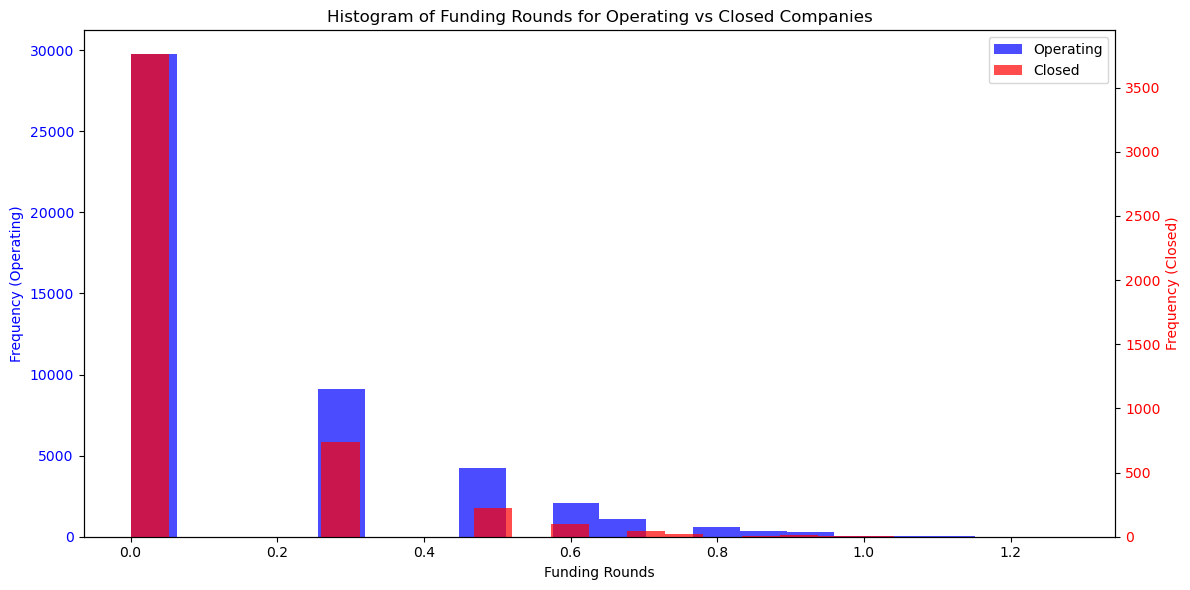

In [3923]:
# Set up the figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Data for operating companies
mask_operating = (df['funding_span'] > 0) & (df['status'] == 'operating')
filtered_df_operating = df[mask_operating]
ratio_operating = np.log10(filtered_df_operating['funding_rounds'])

# Data for closed companies
mask_closed = (df['funding_span'] > 0) & (df['status'] == 'closed')
filtered_df_closed = df[mask_closed]
ratio_closed = np.log10(filtered_df_closed['funding_rounds'])

# Plot histogram for operating companies
n1, bins1, patches1 = ax1.hist(ratio_operating, bins=20, alpha=0.7, color='blue', label='Operating')
ax1.set_xlabel('Funding Rounds')
ax1.set_ylabel('Frequency (Operating)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis
ax2 = ax1.twinx()

# Plot histogram for closed companies
n2, bins2, patches2 = ax2.hist(ratio_closed, bins=20, alpha=0.7, color='red', label='Closed')
ax2.set_ylabel('Frequency (Closed)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Histogram of Funding Rounds for Operating vs Closed Companies')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [3924]:
df['high_funding_rounds'] = np.where(np.log10(df['funding_rounds']) > 0.2, 1, 0)
df_t['high_funding_rounds'] = np.where(np.log10(df_t['funding_rounds']) > 0.2, 1, 0)

#### 2.4 Total funding

Фандинг удалил полностью, во всех комбинациях с любым заполнением, он не давал существенных результатов. Если бы не было лайфтайма, может быть имело бы смысл собирать на его базе признак дальше, но, при его наличии, корреляция получается слишком низкой. Кроме пропусков там еще и много выбросов, в итоге прироста добиться не удалось.

In [3927]:
#df['funding_total_usd'] = df['funding_total_usd'].fillna(-100)

In [3928]:
#average_funding = df.groupby('grouped_category')['funding_total_usd'].mean().reset_index()
#average_funding.columns = ['Category', 'average_funding']

#df = df.merge(average_funding, left_on='grouped_category', right_on='Category', how='left')
#df_t = df_t.merge(average_funding, left_on='grouped_category', right_on='Category', how='left')

#df.drop('Category', axis=1, inplace=True)
#df_t.drop('Category', axis=1, inplace=True)

# Relative funding
#df['relative_funding'] = df.apply(lambda row: (row['funding_total_usd'] - row['average_funding']) / row['average_funding'] if row['average_funding'] != 0 else 0, axis=1)
#df_t['relative_funding'] = df_t.apply(lambda row: (row['funding_total_usd'] - row['average_funding']) / row['average_funding'] if row['average_funding'] != 0 else 0, axis=1)

In [3929]:
#scaler = MinMaxScaler()
#fig, ax1 = plt.subplots(figsize=(12, 6))

# Data for operating companies
#mask_operating = (df['status'] == 'operating')
#filtered_df_operating = df[mask_operating]
#ratio_operating = scaler.fit_transform(filtered_df_operating[['funding_total_usd']])

# Data for closed companies
#mask_closed = (df['status'] == 'closed')
#filtered_df_closed = df[mask_closed]
#ratio_closed = scaler.fit_transform(filtered_df_closed[['funding_total_usd']])

# Plot histogram for operating companies
#n1, bins1, patches1 = ax1.hist(ratio_operating, bins=50, alpha=0.7, color='blue', label='Operating')
#ax1.set_xlabel('Funding Total')
#ax1.set_ylabel('Frequency (Operating)', color='blue')
#ax1.tick_params(axis='y', labelcolor='blue')

#ax2 = ax1.twinx()

# Plot histogram for closed companies
#n2, bins2, patches2 = ax2.hist(ratio_closed, bins=50, alpha=0.7, color='red', label='Closed')
#ax2.set_ylabel('Frequency (Closed)', color='red')
#ax2.tick_params(axis='y', labelcolor='red')

#plt.title('Histogram of Funding Total for Operating vs Closed Companies')
#fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
#plt.tight_layout()
#plt.show()


In [3930]:
#df['log_ratio_total'] = scaler.fit_transform(df['funding_total_usd'].values.reshape(-1, 1)) #/(np.sqrt(df['funding_span'])+1)
#df_t['log_ratio_total'] = scaler.fit_transform(df_t['funding_total_usd'].values.reshape(-1, 1)) #/(np.sqrt(df_t['funding_span'])+1)

df = df.drop('funding_total_usd', axis=1)
df_t = df_t.drop('funding_total_usd', axis=1)

#### 2.5 Funding span

Промежуток фондирования оказался неплохим признаком, но лайфтайм лучше и между ними присутствует коллинеарность. Синтетические признаки на его базе у меня тоже получились "как лайфтайм, только хуже"  

In [3933]:
df

,name,category_list,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,first_funding_at_y,funding_span,country_region,grouped_category,second_category,one_two,high_funding_rounds
0,Lunchgate,online reservations|restaurants,operating,CHE,25,Zurich,Zürich,2,15095,16405,2998,2011,1311,CHE,online reservations,restaurants,online reservations|restaurants,1
1,EarLens,manufacturing|medical|medical devices,operating,USA|CA,CA,SF Bay Area,Redwood City,4,14733,16126,4748,2010,1394,USA|CA,medical devices,manufacturing,medical devices|manufacturing,1
2,Reviva Pharmaceuticals,biotechnology,operating,USA|CA,CA,SF Bay Area,San Jose,3,15572,16253,4383,2012,682,USA|CA,Others,biotechnology,Others|biotechnology,1
3,Sancilio and Company,health care,operating,--,NaN,NaN,NaN,3,15218,16269,5114,2011,1052,--,health care,Others,health care|Others,1
4,WireTough Cylinders,manufacturing,operating,USA|VA,VA,VA - Other,Bristol,1,15371,15371,2791,2012,1,USA|VA,manufacturing,Others,manufacturing|Others,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,entertainment,operating,CAN,ON,Toronto,Kitchener,1,16130,16130,2192,2014,1,CAN,entertainment,Others,entertainment|Others,0
52512,Hello Curry,hospitality,operating,IND,2,Hyderabad,Hyderabad,1,16136,16136,1590,2014,1,IND,hospitality,Others,hospitality|Others,0
52513,Taskforce,email|messaging|productivity software,operating,USA|CA,CA,SF Bay Area,San Francisco,3,14409,14975,2741,2009,567,USA|CA,email,productivity software,email|productivity software,1
52514,NetScaler,security,operating,USA|CA,CA,SF Bay Area,San Jose,6,10560,12478,7336,1998,1919,USA|CA,security,Others,security|Others,1


In [3934]:
#df[df['funding_rounds']==1]['funding_span'] = (-1)
#df[df['funding_rounds']==2]['funding_span'] = (-2)
#df['funding_frq'] = np.sqrt(df['funding_span']/df['funding_rounds'])
#df['funding_frq'] = np.sqrt(df['funding_span']/df['funding_rounds'])

#df['funding_span'] = np.sqrt(df['funding_span'])   #/df['funding_rounds'])
#df_t['funding_span'] = np.sqrt(df_t['funding_span'])

#df['high_funding_span'] = np.where(np.sqrt(df['funding_span'])/(df['first_funding_at_y']+1) > 0.002, 1, 0)
#df_t['high_funding_span'] = np.where(np.sqrt(df_t['funding_span'])/(df_t['first_funding_at_y']+1) > 0.002, 1, 0)

#df['high_funding_span_mix'] = df['high_funding_rounds']+df['high_funding_span']
#df_t['high_funding_span_mix'] = df_t['high_funding_rounds']+df_t['high_funding_span']

#df['log_ratio_span'] = np.sqrt(df['funding_span'])/(df['first_funding_at_y']+1)
#df_t['log_ratio_span'] = np.sqrt(df_t['funding_span'])/(df_t['first_funding_at_y']+1)

Убираем всё ненужное

In [3936]:
df = df.drop('funding_rounds', axis=1)
df_t = df_t.drop('funding_rounds', axis=1)
df = df.drop('funding_span', axis=1)
df_t = df_t.drop('funding_span', axis=1)

df = df.drop('grouped_category', axis=1)
df_t = df_t.drop('grouped_category', axis=1)
df = df.drop('second_category', axis=1)
df_t = df_t.drop('second_category', axis=1)

In [3937]:
df.shape

(52516, 14)

#### 2.6 Lifetime

Используем MinMaxScaler, чтобы удобнее было рассмотреть график

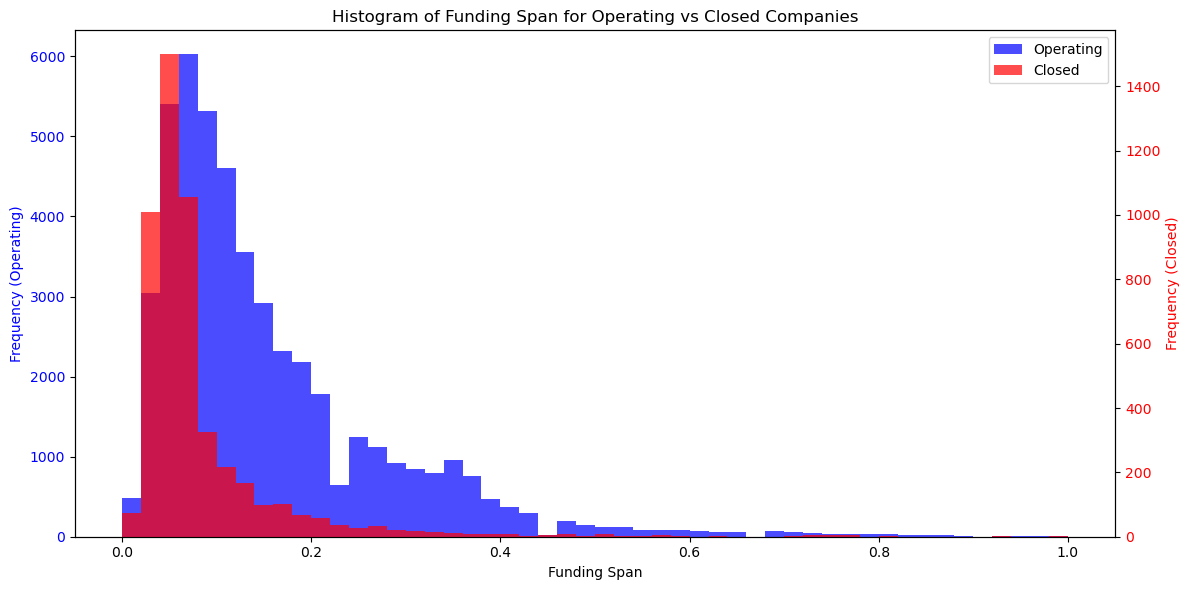

In [3940]:
#train_df['Scaled_Age'] = scaler.fit_transform(train_df['Age'].values.reshape(-1, 1))

# Set up the figure and primary axis
scaler = MinMaxScaler()
fig, ax1 = plt.subplots(figsize=(12, 6))
def log20(x):
    return np.log(x) / np.log(10)
    
# Data for operating companies
mask_operating = (df['lifetime'] > 0) & (df['status'] == 'operating')
filtered_df_operating = df[mask_operating]
ratio_operating = scaler.fit_transform(filtered_df_operating['lifetime'].values.reshape(-1, 1)) 
# Data for closed companies
mask_closed = (df['lifetime'] > 0) & (df['status'] == 'closed')
filtered_df_closed = df[mask_closed]
ratio_closed = scaler.fit_transform(filtered_df_closed['lifetime'].values.reshape(-1, 1)) 
#log20(filtered_df_closed['lifetime'])#/(filtered_df_closed['first_funding_at_y']+1)

# Plot histogram for operating companies
n1, bins1, patches1 = ax1.hist(ratio_operating, bins=50, alpha=0.7, color='blue', label='Operating')
ax1.set_xlabel('Funding Span')
ax1.set_ylabel('Frequency (Operating)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis
ax2 = ax1.twinx()

# Plot histogram for closed companies
n2, bins2, patches2 = ax2.hist(ratio_closed, bins=50, alpha=0.7, color='red', label='Closed')
ax2.set_ylabel('Frequency (Closed)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Histogram of Funding Span for Operating vs Closed Companies')
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()

log10 дал чуть лучшие результаты на Phik matrix, но особенной разницы нет. Можно оставить и просто Lifetime.

In [3942]:
df['lifetime_log'] = np.log10(df['lifetime'])
df_t['lifetime_log'] = np.log10(df_t['lifetime'])
df = df.drop('lifetime', axis=1)
df_t = df_t.drop('lifetime', axis=1)
#df = df.drop('funding_span', axis=1)
#df_t = df_t.drop('funding_span', axis=1)

### 3. Research

In [3944]:
df_temp = df
df_temp = df_temp.drop(['country_code', 'state_code', 'region', 'city',
                        'category_list', 'name','first_funding_at','first_funding_at_y'], axis=1)

df_t_temp = df_t
df_t_temp = df_t_temp.drop(['country_code', 'state_code', 'region', 'city',
                            'category_list', 'name','first_funding_at', 'first_funding_at_y'], axis=1)

In [3945]:
df_temp.shape

(52516, 6)

In [3946]:
num_cols = df_temp.select_dtypes(include=[np.number]).columns
print("Numeric columns:", num_cols)

Numeric columns: Index(['last_funding_at', 'high_funding_rounds', 'lifetime_log'], dtype='object')


In [3947]:
non_num_cols = df_temp.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_num_cols)

Non-numeric columns: Index(['status', 'country_region', 'one_two'], dtype='object')


Строил графики для количественных признаков, но их, в итоге, почти не осталось 

In [3949]:
#def scat(col0, col1, col2):
#    for c in df_temp[col0].unique():
#        plt.scatter(df_temp[df_temp[col0]==c][col1], df_temp[df_temp[col0]==c][col2],label = f'{col0} - {c}', alpha=0.1)
#    plt.xlabel(col1)
#    plt.ylabel(col2)
#    plt.legend()
#    plt.show()
#for q1 in num_cols:
#    for q2 in num_cols:
#        scat('status', q2, q1)
#    print()

#### Phik

/opt/anaconda3/lib/python3.12/site-packages/phik/bivariate.py:241: UserWarning: Many cells: 1891879. Are interval variables set correctly?
  warnings.warn(


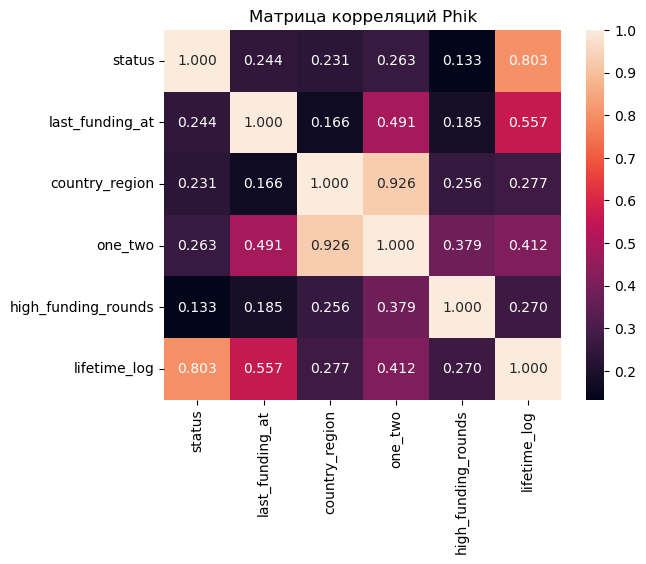

In [3951]:
sns.heatmap(df_temp.phik_matrix(interval_cols=num_cols), annot=True, fmt='.3f')
plt.title('Матрица корреляций Phik')
plt.show()

### 4. Pipeline and model

In [3953]:
df_1 = df_temp
df_t1 = df_t
lb = LabelEncoder()
df_1['status'] = lb.fit_transform(df_1['status'])

In [3954]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(df_1.drop('status', axis=1), df_1['status'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

In [3955]:
def label_encode_columns(X):
    X_encoded = X.copy()
    for column in X.columns:
        le = LabelEncoder()
        X_encoded[column] = le.fit_transform(X_encoded[column].astype(str))
    return X_encoded
    
label_encoder = FunctionTransformer(label_encode_columns)

In [3956]:
non_num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('encoder', label_encoder)
])


In [3957]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [3958]:
num_cols = X_test.select_dtypes(include=[np.number]).columns
non_num_cols = X_test.select_dtypes(exclude=[np.number]).columns
print("Numeric columns:", num_cols)
print("Non-numeric columns:", non_num_cols)

Numeric columns: Index(['last_funding_at', 'high_funding_rounds', 'lifetime_log'], dtype='object')
Non-numeric columns: Index(['country_region', 'one_two'], dtype='object')


In [3959]:
preprocessing = ColumnTransformer(
    transformers=[
        ('num', num_pipe, num_cols),
        ('non_num_pipe', label_encoder, non_num_cols)
    ])

In [3960]:
warnings.filterwarnings('ignore')

Пробовал разные методы андерсемплинга, в итоге только TomekLinks что-то дал. В основном, результаты даже ухудшались

In [3962]:
pipe_final = ImblearnPipeline([
    ('preprocessor', preprocessing),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('model', LogisticRegression())
])


In [3963]:
stratified_cv = StratifiedKFold(n_splits=4)
c_range = [0.2,0.4,0.6,0.8,1,2,5]
model_learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

В других соревнованиях на Каггл увидел, что ребята часто используют XGBoost и решил попробовать вместо деревьев, которые у меня до этого лидировали. Получилось поднять метрику на пару процентов

In [3965]:
param_grid = [
     {
        'model': [XGBClassifier()],
        'model__n_estimators': range(10,100, 10),
        'model__learning_rate': model_learning_rate,
        'model__max_depth': range(3, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'select__k': range(3,6),
        'select__score_func': [mutual_info_classif, f_classif],
        'model__min_child_weight': range(1, 6),
        'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'model__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 1, 10, 100],
        'model__reg_lambda': [0, 0.1, 1, 10, 100]

    },
]

In [3966]:

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=stratified_cv,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    n_iter=1000
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_.round(3))

y_test_pred = randomized_search.best_estimator_.predict(X_test)
print(f'Метрика f1_score на тестовой выборке: {f1_score(y_test, y_test_pred).round(3)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['last_funding_at', 'high_funding_rounds', 'lifetime_log'], dtype='object')),
                                                 ('non_num_pipe',
                                                  FunctionTransformer(func=<function label_encode_columns at 0x387620720>),
                                                  Index(['country_region', 'one_two'], dtype='object'))])),
                ('TomekLinks', TomekLinks()), ('select', Selec...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.4,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
      

In [3967]:
print("Best params:", randomized_search.best_params_)
print("Best F1-score:", randomized_search.best_score_)

Best params: {'select__score_func': <function f_classif at 0x1684e09a0>, 'select__k': 5, 'preprocessor__num': RobustScaler(), 'model__subsample': 0.8, 'model__reg_lambda': 10, 'model__reg_alpha': 1, 'model__n_estimators': 70, 'model__min_child_weight': 3, 'model__max_depth': 5, 'model__learning_rate': 0.4, 'model__gamma': 0.1, 'model__colsample_bytree': 0.8, 'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
 

In [3968]:
pd.set_option('display.max_colwidth', None)

In [3969]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  Index(['last_funding_at', 'high_funding_rounds', 'lifetime_log'], dtype='object')),
                                                 ('non_num_pipe',
                                                  FunctionTransformer(func=<function label_encode_columns at 0x387620720>),
                                                  Index(['country_region', 'one_two'], dtype='object'))])),
                ('TomekLinks', TomekLinks()), ('select', Selec...
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.4,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=70,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [3970]:
X_test_temp = X_test

In [3971]:
X_test_temp['preds'] = randomized_search.best_estimator_.predict(X_test)

In [3972]:
X_test_temp['status'] = y_test

Модель часто ошибается на минорном классе, но это было ожидаемо, улучшить, к сожалению, не получилось

In [3974]:
(X_test_temp[(X_test_temp['preds'] == 0)&(X_test_temp['status'] == 0)]['status'].count()
 /X_test_temp[X_test_temp['status'] == 0]['status'].count()).round(3)

0.821

In [3975]:
(X_test_temp[(X_test_temp['preds'] == 1)&(X_test_temp['status'] == 1)]['status'].count()
 /X_test_temp[X_test_temp['status'] == 1]['status'].count()).round(3)

0.994

In [3976]:
df_t1

,name,category_list,country_code,state_code,region,city,first_funding_at,last_funding_at,first_funding_at_y,country_region,one_two,high_funding_rounds,lifetime_log
0,Crystalsol,clean technology,NIC,17,NaN,NaN,14426,14426,2009,NIC,online reservations|restaurants,0,3.544
1,JBI Fish & Wings,hospitality,USA|TN - Other,TN,TN - Other,Humboldt,14818,14818,2010,Others,medical devices|manufacturing,0,3.434
2,COINPLUS,finance,LUX,3,Esch-sur-alzette,Esch-sur-alzette,16205,16331,2014,LUX,Others|biotechnology,1,3.112
3,Imagine Communications,software|video|video streaming,USA|San Diego,CA,San Diego,San Diego,12784,14719,2005,Others,health care|Others,1,3.677
4,DNA13,software,CAN,ON,Ottawa,Ottawa,13641,13641,2007,CAN,manufacturing|Others,0,3.793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,recruiting,USA|SF Bay Area,CA,SF Bay Area,Sunnyvale,15522,15522,2012,Others,financial services|finance,0,3.355
13121,GlobaTrek,software,USA|SF Bay Area,CA,SF Bay Area,Mountain View,15979,15979,2013,Others,high tech|software,0,3.341
13122,Inkd.com,design|ecommerce|marketplaces|printing,USA|Seattle,WA,Seattle,Seattle,14123,15153,2008,Others,Others|hardware and software,1,3.466
13123,AdWill,advertising exchanges|mobile|mobile advertising,USA|New York City,NY,New York City,New York,16340,16378,2014,Others,ecommerce|Others,1,3.142


In [3977]:
df_t1 = df_t1.fillna(method='ffill')

In [3978]:
Comp = pd.DataFrame()
Comp = df_t1
Comp['status'] = randomized_search.best_estimator_.predict(df_t1)

In [3979]:
Comp

,name,category_list,country_code,state_code,region,city,first_funding_at,last_funding_at,first_funding_at_y,country_region,one_two,high_funding_rounds,lifetime_log,status
0,Crystalsol,clean technology,NIC,17,NaN,NaN,14426,14426,2009,NIC,online reservations|restaurants,0,3.544,1
1,JBI Fish & Wings,hospitality,USA|TN - Other,TN,TN - Other,Humboldt,14818,14818,2010,Others,medical devices|manufacturing,0,3.434,1
2,COINPLUS,finance,LUX,3,Esch-sur-alzette,Esch-sur-alzette,16205,16331,2014,LUX,Others|biotechnology,1,3.112,1
3,Imagine Communications,software|video|video streaming,USA|San Diego,CA,San Diego,San Diego,12784,14719,2005,Others,health care|Others,1,3.677,1
4,DNA13,software,CAN,ON,Ottawa,Ottawa,13641,13641,2007,CAN,manufacturing|Others,0,3.793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,recruiting,USA|SF Bay Area,CA,SF Bay Area,Sunnyvale,15522,15522,2012,Others,financial services|finance,0,3.355,1
13121,GlobaTrek,software,USA|SF Bay Area,CA,SF Bay Area,Mountain View,15979,15979,2013,Others,high tech|software,0,3.341,1
13122,Inkd.com,design|ecommerce|marketplaces|printing,USA|Seattle,WA,Seattle,Seattle,14123,15153,2008,Others,Others|hardware and software,1,3.466,1
13123,AdWill,advertising exchanges|mobile|mobile advertising,USA|New York City,NY,New York City,New York,16340,16378,2014,Others,ecommerce|Others,1,3.142,1


In [3980]:
Comp['name'] = df_t['name']
comp = Comp[['name','status']] 
comp['status'] = comp['status'].astype(str)
comp.loc[comp['status'] == '1', 'status'] = 'operating'
comp.loc[comp['status'] == '0', 'status'] = 'closed'

In [3981]:
comp['status'].value_counts(normalize=True)

status
operating   0.919
closed      0.081
Name: proportion, dtype: float64

In [3982]:
comp.to_csv('comp.csv', index=False)

In [3983]:
Omp = pd.read_csv('comp.csv')
Omp

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


### Conclusion

В итоге получилась максимально простая модель, всего 5 признаков, из которых один можно убрать без особого вреда для качества предсказаний. В реальной работе, конечно, желательно убрать или сократить лафйтайм и все суммарные фандинги, раунды и т.д. или модель просто будет обходить новые стартапы. Для категорий тоже есть свои сложности, вряд ли приложения для windows phone сейчас это хорошая идея, хотя исторически эти компании возможно и неплохо работали, а потом перепрофилировались. 
Можно также попробовать увязать страны и регионы с направленностью стартапа, например калифорнийский софт и Лондонский банкинг, но для Каггла мне этот подход прироста не дал.

Сенситивити аналисис дополнительно делать не стал, мне показалось, что модель настолько простая, что примерно и так понятно, какие признаки больше влияли на результат 